In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [16]:
train_dir = "/content/drive/MyDrive/Dataset/train"
validation_dir = "/content/drive/MyDrive/Dataset/val"

BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 188 files belonging to 2 classes.


In [17]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 47 files belonging to 2 classes.


In [18]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [19]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 1


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [21]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

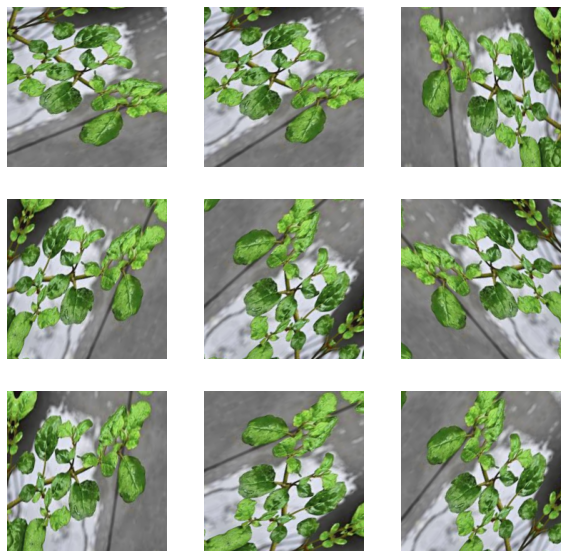

In [22]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [24]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

In [25]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

94683136/94668760 [==============================] - 1s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [26]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2048)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [27]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [28]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [29]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [30]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [31]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [32]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [34]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [35]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2/2 [==============================] - 9s 1s/step - loss: 0.9012 - accuracy: 0.4194


In [36]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.90
initial accuracy: 0.42


In [37]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
12/12 [==============================] - 11s 390ms/step - loss: 0.9279 - accuracy: 0.4309 - val_loss: 0.9014 - val_accuracy: 0.4516
Epoch 2/10
12/12 [==============================] - 6s 302ms/step - loss: 0.8986 - accuracy: 0.4574 - val_loss: 0.7927 - val_accuracy: 0.4516
Epoch 3/10
12/12 [==============================] - 6s 297ms/step - loss: 0.8742 - accuracy: 0.4628 - val_loss: 0.8168 - val_accuracy: 0.4194
Epoch 4/10
12/12 [==============================] - 6s 301ms/step - loss: 0.8024 - accuracy: 0.5000 - val_loss: 0.8096 - val_accuracy: 0.4516
Epoch 5/10
12/12 [==============================] - 6s 295ms/step - loss: 0.8033 - accuracy: 0.5160 - val_loss: 0.8267 - val_accuracy: 0.3548
Epoch 6/10
12/12 [==============================] - 6s 297ms/step - loss: 0.7994 - accuracy: 0.5053 - val_loss: 0.7423 - val_accuracy: 0.5161
Epoch 7/10
12/12 [==============================] - 6s 294ms/step - loss: 0.7505 - accuracy: 0.5372 - val_loss: 0.6507 - val_accuracy: 0.5806
Epoch

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

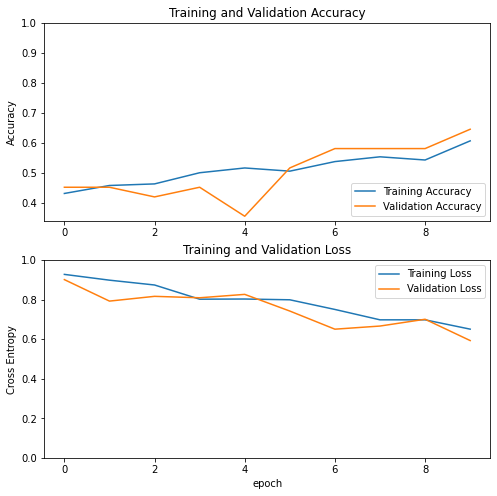

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig("Initial_10_epoch.png")

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [39]:
base_model.trainable = True

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [41]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [43]:
len(model.trainable_variables)

38

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [44]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/30
12/12 [==============================] - 15s 458ms/step - loss: 0.5546 - accuracy: 0.6489 - val_loss: 0.3983 - val_accuracy: 0.8065
Epoch 11/30
12/12 [==============================] - 6s 346ms/step - loss: 0.3633 - accuracy: 0.8191 - val_loss: 0.3632 - val_accuracy: 0.8065
Epoch 12/30
12/12 [==============================] - 6s 343ms/step - loss: 0.2655 - accuracy: 0.8936 - val_loss: 0.1993 - val_accuracy: 0.9355
Epoch 13/30
12/12 [==============================] - 7s 352ms/step - loss: 0.1587 - accuracy: 0.9468 - val_loss: 0.1492 - val_accuracy: 0.9355
Epoch 14/30
12/12 [==============================] - 7s 353ms/step - loss: 0.1411 - accuracy: 0.9521 - val_loss: 0.1690 - val_accuracy: 0.9032
Epoch 15/30
12/12 [==============================] - 7s 350ms/step - loss: 0.1042 - accuracy: 0.9521 - val_loss: 0.1507 - val_accuracy: 0.9355
Epoch 16/30
12/12 [==============================] - 7s 350ms/step - loss: 0.1107 - accuracy: 0.9628 - val_loss: 0.1642 - val_accuracy: 0.903

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [45]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [46]:
print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.4308510720729828, 0.457446813583374, 0.46276596188545227, 0.5, 0.5159574747085571, 0.5053191781044006, 0.5372340679168701, 0.5531914830207825, 0.542553186416626, 0.6063829660415649, 0.6489361524581909, 0.8191489577293396, 0.8936170339584351, 0.9468085169792175, 0.9521276354789734, 0.9521276354789734, 0.9627659320831299, 0.9946808218955994, 0.978723406791687, 0.978723406791687, 0.9840425252914429, 0.9840425252914429, 0.9946808218955994, 0.9840425252914429, 1.0, 0.9840425252914429, 0.9946808218955994, 1.0, 1.0, 1.0, 1.0]
[0.4516128897666931, 0.4516128897666931, 0.4193548262119293, 0.4516128897666931, 0.35483869910240173, 0.5161290168762207, 0.5806451439857483, 0.5806451439857483, 0.5806451439857483, 0.6451612710952759, 0.8064516186714172, 0.8064516186714172, 0.9354838728904724, 0.9354838728904724, 0.9032257795333862, 0.9354838728904724, 0.9032257795333862, 0.8709677457809448, 0.9032257795333862, 0.9032257795333862, 0.9677419066429138, 0.9677419066429138, 0.9354838728904724, 0.93548387

In [9]:
acc = [0.4308510720729828, 0.457446813583374, 0.46276596188545227, 0.5, 0.5159574747085571, 0.5053191781044006, 0.5372340679168701, 0.5531914830207825, 0.542553186416626, 0.6063829660415649, 0.6489361524581909, 0.8191489577293396, 0.8936170339584351, 0.9468085169792175, 0.9521276354789734, 0.9521276354789734, 0.9627659320831299, 0.9946808218955994, 0.978723406791687, 0.978723406791687, 0.9840425252914429, 0.9840425252914429, 0.9946808218955994, 0.9840425252914429, 1.0, 0.9840425252914429, 0.9946808218955994, 1.0, 1.0, 1.0, 1.0]
val_acc = [0.4516128897666931, 0.4516128897666931, 0.4193548262119293, 0.4516128897666931, 0.45483869910240173, 0.5161290168762207, 0.5806451439857483, 0.5806451439857483, 0.5806451439857483, 0.6451612710952759, 0.8064516186714172, 0.8064516186714172, 0.9354838728904724, 0.9354838728904724, 0.9032257795333862, 0.9354838728904724, 0.9032257795333862, 0.8709677457809448, 0.9032257795333862, 0.9032257795333862, 0.9677419066429138, 0.9677419066429138, 0.9354838728904724, 0.9354838728904724, 0.9354838728904724, 0.9677419066429138, 1.0, 1.0, 0.9677419066429138, 1.0, 0.9354838728904724]
loss = [0.9278895854949951, 0.8985964059829712, 0.8742126822471619, 0.8023576736450195, 0.8032529354095459, 0.7993612289428711, 0.7504667043685913, 0.6979605555534363, 0.6979778409004211, 0.6508027911186218, 0.5545769929885864, 0.36330556869506836, 0.26548898220062256, 0.15874995291233063, 0.14112631976604462, 0.10415568202733994, 0.11068176478147507, 0.04015231505036354, 0.06577666848897934, 0.046151190996170044, 0.03839986398816109, 0.044425155967473984, 0.048100944608449936, 0.020374342799186707, 0.008038213476538658, 0.06179666891694069, 0.010644313879311085, 0.007708519697189331, 0.010581010952591896, 0.008556432090699673, 0.002237513894215226]
val_loss = [0.9014023542404175, 0.7927238345146179, 0.8168033361434937, 0.8095565438270569, 0.8267444372177124, 0.7423442602157593, 0.6506603956222534, 0.6665273308753967, 0.7008749842643738, 0.5930525064468384, 0.3982986807823181, 0.36322861909866333, 0.19928525388240814, 0.14917193353176117, 0.16902361810207367, 0.1506502777338028, 0.16422675549983978, 0.20121268928050995, 0.17238852381706238, 0.1440940499305725, 0.05876706913113594, 0.07871308922767639, 0.11881571263074875, 0.125418820977211, 0.11379047483205795, 0.04908137395977974, 0.055473119020462036, 0.04758882522583008, 0.08849930018186569, 0.019138028845191002, 0.08324456214904785]

In [3]:
import matplotlib.pyplot as plt


In [5]:
initial_epochs = 10

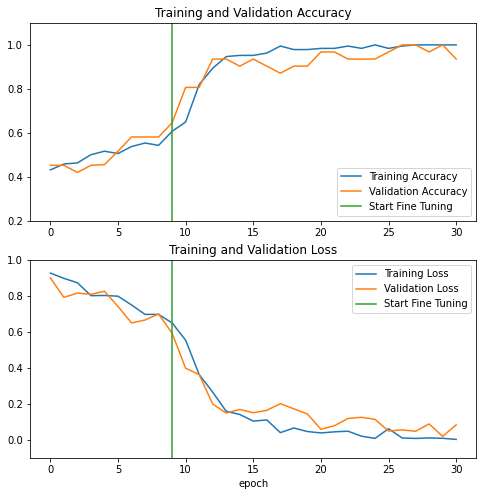

In [11]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1.1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([-0.1, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig("Final_plot.png")

In [48]:
model.save("mobilenet1.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [49]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 961ms/step - loss: 0.1728 - accuracy: 0.8750
Test accuracy : 0.875


And now you are all set to use this model to predict if your pet is a cat or dog.

In [50]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

Predictions:
 [0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1]
Labels:
 [0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1]


In [52]:
from sklearn import metrics


In [53]:
print("accuracy : ",metrics.accuracy_score(label_batch,predictions,normalize=True))
print('Confusion Matrix')
cm = metrics.confusion_matrix(label_batch, predictions)
print(cm)
print('Classification Report')
print(metrics.classification_report(label_batch, predictions))

accuracy :  0.9375
Confusion Matrix
[[6 0]
 [1 9]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.90      0.95        10

    accuracy                           0.94        16
   macro avg       0.93      0.95      0.94        16
weighted avg       0.95      0.94      0.94        16



## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
